# Позиция: джуниор дата сайнтист
# Компания: консалтинг

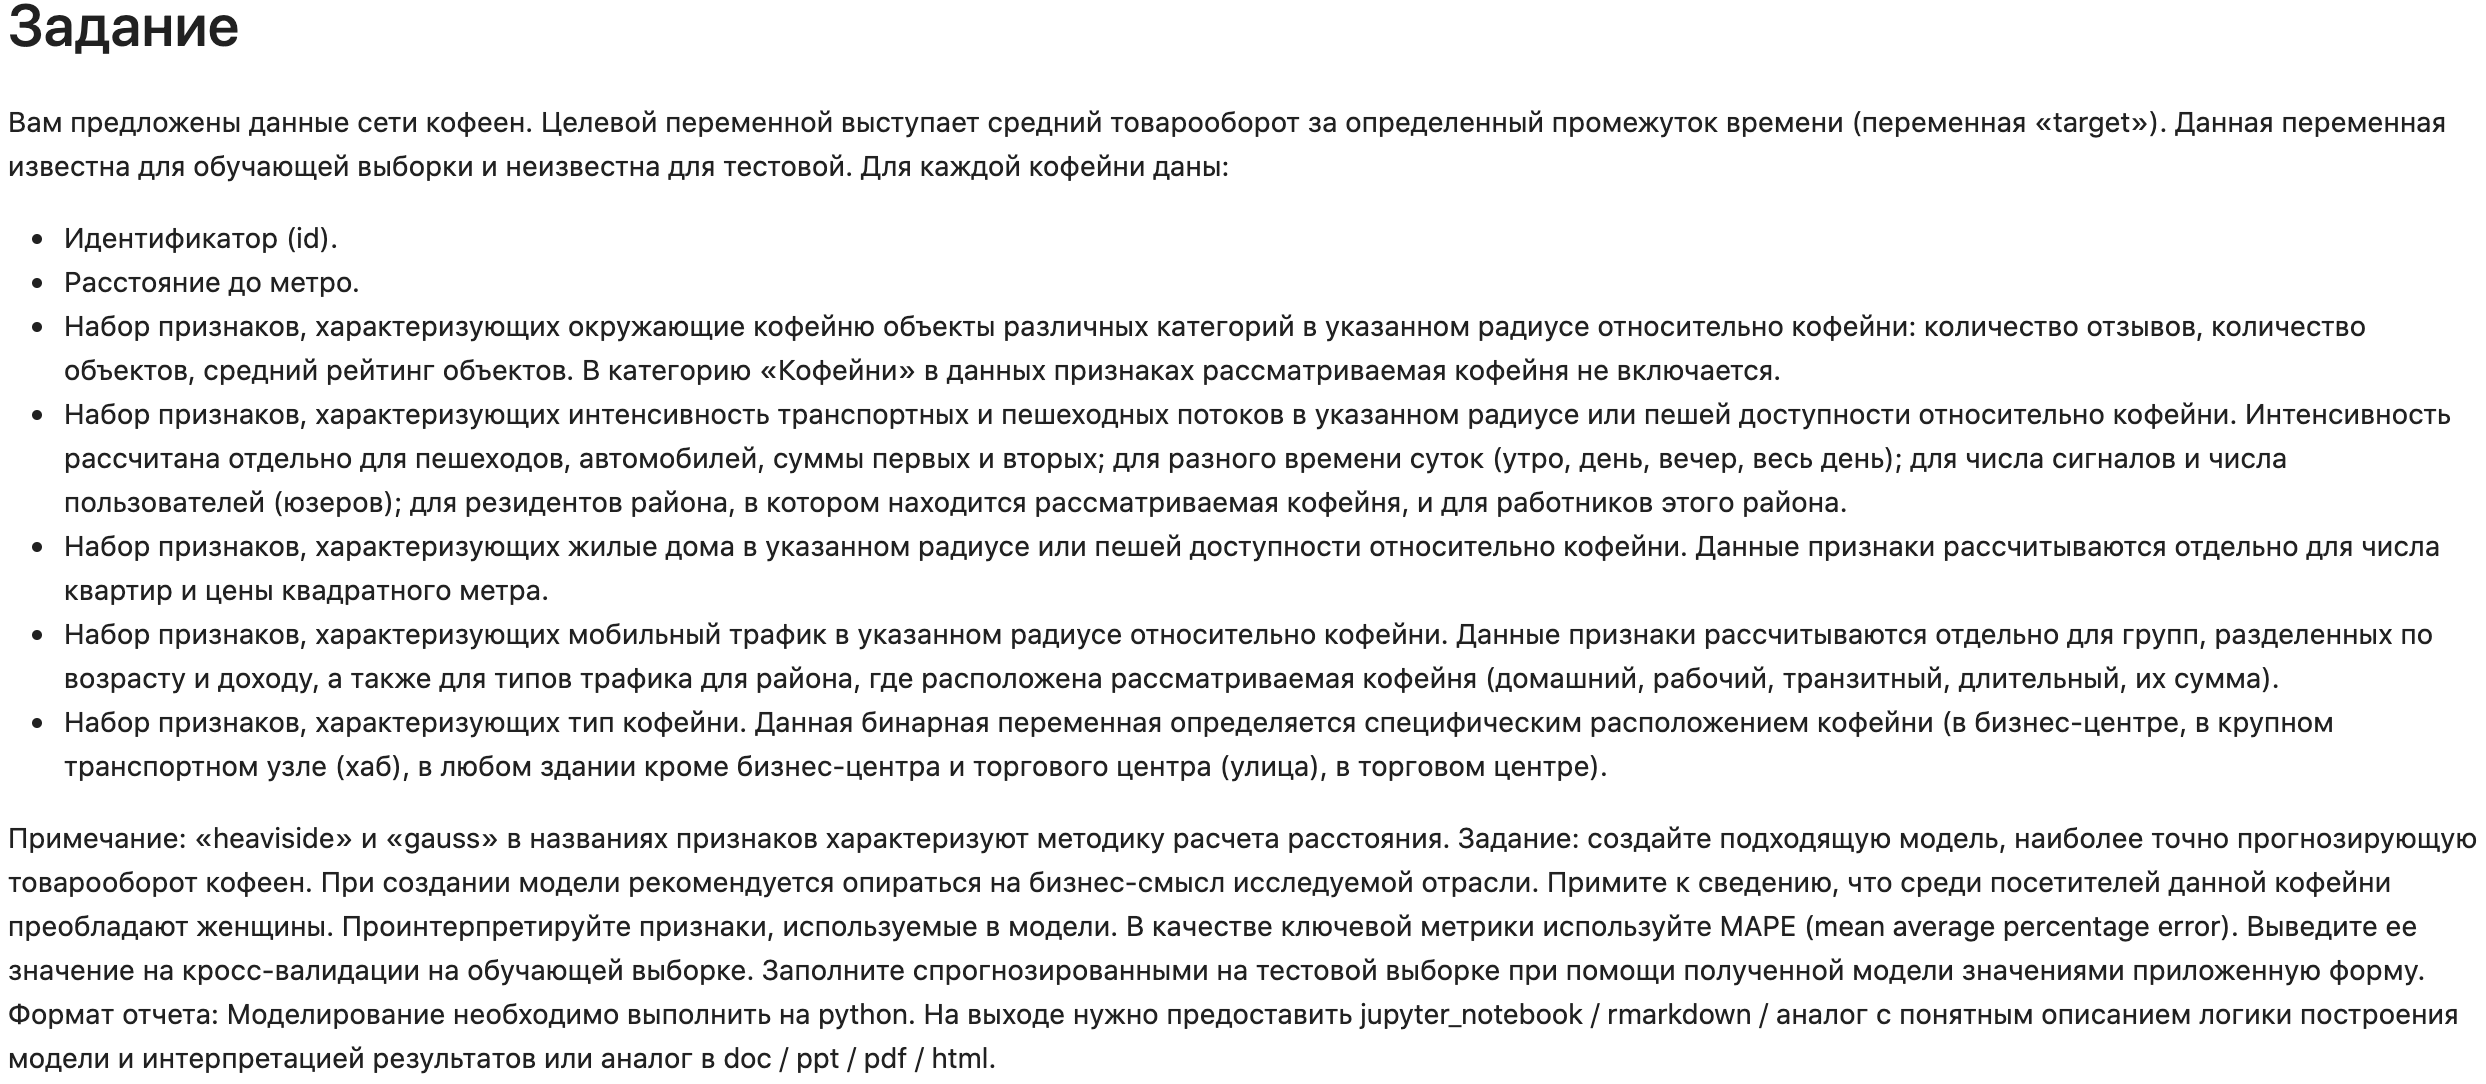

Structure:  
1. [Packages](#1)
2. [Load data](#2)
3. [Preprocessing](#3)
4. [Implementing models](#4)
5. [Secondary functions](#5)
6. [All together](#6)

<a id='1'></a>
# Packages

In [5]:
!pip install scikit-optimize catboost xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 9.4 MB/s 
     |████████████████████████████████| 76.6 MB 76 kB/s 


In [60]:
import pandas as pd
import numpy as np
import itertools
import random
import os 

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.algorithms import quantile

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error

In [7]:
import warnings
warnings.simplefilter('ignore')

In [8]:
DEFAULT_RANDOM_SEED = 1

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seedBasic()

<a id='2'></a>
# Load data

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_excel(file)
    df = reduce_mem_usage(df)
    return df

In [10]:
df = import_data('dataset_renamed.xlsx')

Memory usage of dataframe is 1.75 MB
Memory usage after optimization is: 0.51 MB
Decreased by 70.8%


In [11]:
df

,id,target,Расстояние до метро,"Суммарное кол-во отзывов в категории ""АЗС"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Алкомаркеты"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Аптеки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Банки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Бизнес_центры"" в радиусе 150м","Суммарное кол-во отзывов в категории ""ВУЗы"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Вокзалы"" в радиусе 150м",...,Суммарный вечерний трафик сигналов рабочих в радиусе 140м,Суммарный трафик сигналов рабочих в радиусе 140м,Суммарный утренний трафик юзеров рабочих в радиусе 140м,Суммарный дневной трафик юзеров рабочих в радиусе 140м,Суммарный вечерний трафик юзеров рабочих в радиусе 140м,Суммарный трафик юзеров рабочих в радиусе 140м,Тип БЦ,Тип хаб,Тип улица,Тип ТЦ
0,60,1.292969,5528.0,0,274,56,156,249,0,0,...,33,187,3,6,3,6,0,0,1,0
1,50,1.674805,16240.0,0,0,719,402,0,0,0,...,303,1302,9,12,11,15,0,0,0,1
2,17,1.140625,6400.0,0,194,425,271,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,15,1.352539,2256.0,0,0,0,0,1737,83,0,...,52,315,6,7,5,10,0,0,1,0
4,74,1.325195,5812.0,0,0,71,0,0,0,0,...,257,1189,2,2,2,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,112,NaN,19888.0,0,0,193,32,0,0,0,...,185,1074,6,6,7,8,0,0,0,1
94,117,NaN,485.5,0,1258,237,103,372,60,0,...,351,1529,9,10,10,13,0,0,1,0
95,126,NaN,2420.0,0,146,346,16,20,0,0,...,129,437,8,10,6,14,0,0,1,0
96,144,NaN,12000.0,0,85,414,547,0,0,0,...,91,309,10,10,9,12,0,0,1,0


In [12]:
len(df.select_dtypes(include = np.number).columns)

2335

Categorical data are binary encoded (last columns in data).

<a id='3'></a>
# Preprocessing

## Split data

In [13]:
data = df[~df['target'].isnull()]
pred = df[df['target'].isnull()]

features = data.columns.drop(['id', 'target'])
target = data['target']
target *= 10**6
target = target.round(0)
pred.drop(['id', 'target'], axis=1, inplace=True)

print('Train rows:', data.shape[0])
print('Predicion rows:', pred.shape[0])
print('Data columns:', len(features))

Train rows: 88
Predicion rows: 10
Data columns: 2333


As we can see there are few observations and huge amount of features. It's the main issue causes overfitting. Let's use some tips to wrestle it:

*   Select features
*   Use simple model
*   Use more foldes for validation (as extreme case LOOCV)

But first of all we should preprocesse our data.


## Drop dublicates
We've got too much features. It seems strange. Let't make *dirty hack*.

In [14]:
print(f'Such amount of columns was {len(features)}.')
features = data[features].T.drop_duplicates(keep='first').T.columns
print(f'Such amount of columns becomes {len(features)}.')

Such amount of columns was 2333.
Such amount of columns becomes 1907.


## Work with nans

In [15]:
%%time

percent_missing = data[features].isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

CPU times: user 10.2 ms, sys: 3.02 ms, total: 13.3 ms
Wall time: 17.5 ms


In [16]:
missing_value_df.head()

,percent_missing
Расстояние до метро,0.0
"Суммарное кол-во отзывов в категории ""АЗС"" в радиусе 150м",0.0
"Суммарное кол-во отзывов в категории ""Алкомаркеты"" в радиусе 150м",0.0
"Суммарное кол-во отзывов в категории ""Аптеки"" в радиусе 150м",0.0
"Суммарное кол-во отзывов в категории ""Банки"" в радиусе 150м",0.0


In [17]:
missing_value_df.describe()

,percent_missing
count,1907.000000
mean,10.297187
std,23.484561
min,0.000000
25%,0.000000
50%,0.000000
75%,4.081633
max,89.795918


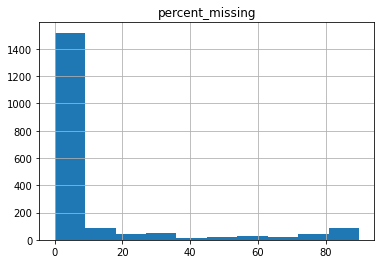

In [18]:
missing_value_df.hist();

There is no rule of thumb for choosing missing values threshold to drop columns. Let's define it as: $q_{3} +1.5IQM$. Unfortunately, chance of loosing important information still exists.

In [19]:
IQM = (missing_value_df.percent_missing.quantile(0.75) - missing_value_df.percent_missing.quantile(0.25))
threshold = missing_value_df.percent_missing.quantile(0.75) + 1.5*IQM
print(threshold)

10.204081632653061


In [20]:
mis_cols = missing_value_df[(missing_value_df.percent_missing != 0) & (missing_value_df.percent_missing  < threshold)].index.tolist()

In [21]:
features = missing_value_df.query('percent_missing < @threshold').index.tolist()

## Impute data
Now it's time to impute missing values. Trees can easy handle missing data, but for linear models we should exchange it. Let's use general approch (imputing medianes).

In [22]:
imp_mean = SimpleImputer( strategy='median')
imp_mean.fit(data[features])
imputed_data = pd.DataFrame(imp_mean.transform(data[features]), columns=features)
imputed_pred = pd.DataFrame(imp_mean.transform(pred[features]), columns=features)

## Get rid of constant data

In [23]:
sel = VarianceThreshold(threshold=0)
sel.fit(imputed_data)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [24]:
# The number of features that are not constant
sum(sel.get_support())

1504

In [25]:
names = imputed_data.columns[sel.get_support()].tolist()

In [26]:
print(f'{imputed_data.shape[1]} colums were before dropping.')

clean_data = pd.DataFrame(sel.transform(imputed_data), columns=names)
clean_pred = pd.DataFrame(sel.transform(imputed_pred), columns=names)

print(f'{clean_data.shape[1]} colums stay after.')

1534 colums were before dropping.
1504 colums stay after.


## Remove low-variance data

In [27]:
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(clean_data)  # fit finds the features with low variance

VarianceThreshold(threshold=0.01)

In [28]:
sum(sel.get_support())

1504

No such data.

## Drop highly correlated features

In [29]:
%%time

# Create correlation matrix
corr_matrix = clean_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f'{clean_data.shape[1]} colums were before dropping.')

# Drop features 
clean_data.drop(to_drop, axis=1, inplace=True)
clean_pred.drop(to_drop, axis=1, inplace=True)

print(f'{clean_data.shape[1]} colums stay after.')

1504 colums were before dropping.
437 colums stay after.
CPU times: user 906 ms, sys: 17.9 ms, total: 924 ms
Wall time: 919 ms


## Finally select important features
The usual rule of thumb is that there be five or ten times as many samples as variable. So we need about 10 features.

### First approach
Let's use recursive feature elimination with cross-validation to select the number of features. 

In [30]:
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import RFECV

In [31]:
# Create the RFE object and compute a cross-validated score
# We'll use model with hyperparametrs which controlling overfitting 
m = XGBRegressor(
    objective ='reg:squarederror',
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=m,
    step=1,
    cv=ShuffleSplit(5),
    scoring=make_scorer(mean_absolute_percentage_error),
    min_features_to_select=min_features_to_select
)

rfecv.fit(clean_data, target)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 8


In [32]:
imp_cols_1 = clean_data.columns[rfecv.support_].tolist()

In [33]:
len(imp_cols_1)

8

In [34]:
imp_cols_1

['Суммарное кол-во отзывов в категории "Хозтоварыидом" в радиусе 150м',
 'Суммарное количество объектов в категории "Метро_МЦК_ж/д" в радиусе 150м',
 'Средний средний рейтинг объектов в категории "Общепит" в радиусе 150м',
 'Средний средний рейтинг объектов в категории "Косметика" в радиусе 500м',
 'Максимальный дневной пешеходный трафик юзеров в радиусе 500м',
 'Суммарный утренний автомобильный трафик сигналов резидентов в радиусе 500м',
 'Суммарный утренний автомобильный трафик сигналов резидентов в радиусе 700м',
 'Суммарный утренний пешеходный трафик сигналов в радиусе 140м']

### Second approach
Let's select 10 features by extra tres's feature importance. And after that choose some of them by brute force on test.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
        clean_data, target, test_size=.2, random_state=42)

In [36]:
from sklearn.ensemble import ExtraTreesClassifier

TOP_FEATURES = 10

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]

print('Top features:')
for f in range(TOP_FEATURES):
    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))

Top features:
1. feature 126 (0.013456)
2. feature 279 (0.007403)
3. feature 420 (0.006579)
4. feature 396 (0.006376)
5. feature 399 (0.005820)
6. feature 139 (0.005814)
7. feature 361 (0.005552)
8. feature 28 (0.005537)
9. feature 384 (0.005483)
10. feature 237 (0.005436)


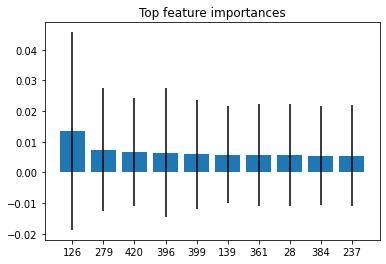

In [37]:
plt.figure()
plt.title('Top feature importances')
plt.bar(
    range(TOP_FEATURES), 
    importances[indices],
    yerr=std[indices], 
)
plt.xticks(range(TOP_FEATURES), indices)
plt.show()

In [38]:
top_features = clean_data.columns[indices].tolist()

In [39]:
for n, col in enumerate(top_features):
  print(f'Top {n+1} feature is {col}.')

Top 1 feature is Суммарное количество объектов в категории "АЗС" в радиусе 500м.
Top 2 feature is Средний рабочий мобильный трафик в радиусе 150м heaviside.
Top 3 feature is Суммарный вечерний пешеходный трафик юзеров резидентов в радиусе 140м.
Top 4 feature is Максимальный вечерний пешеходный трафик юзеров рабочих в радиусе 150м.
Top 5 feature is Средний вечерний автомобильный трафик юзеров рабочих в радиусе 150м.
Top 6 feature is Суммарное количество объектов в категории "Сетевыепродукты" в радиусе 500м.
Top 7 feature is Суммарный утренний пешеходный трафик сигналов рабочих в радиусе 500м.
Top 8 feature is Суммарное кол-во отзывов в категории "Банки" в радиусе 300м.
Top 9 feature is Средний дневной пешеходный трафик сигналов рабочих в радиусе 500м.
Top 10 feature is Суммарное количество объектов в категории "Аптеки" в радиусе 20м.


In [40]:
X_train, X_test = X_train[top_features], X_test[top_features]

In [41]:
%%time

indexes = list(itertools.product([0, 1], repeat=TOP_FEATURES))
indexes

scores_train = dict()
scores_test = dict()

for i, ind in enumerate(indexes):
    ind = np.array(ind, dtype=bool)

    X_train_low = X_train.loc[:, ind].values
    X_test_low = X_test.loc[:, ind].values

    w = np.linalg.inv(X_train_low.T@X_train_low)@X_train_low.T@y_train


    scores_train[i] = np.mean((X_train_low@w - y_train)**2)
    scores_test[i] = np.mean((X_test_low@w - y_test)**2)

best_train = sorted(scores_train, key=lambda x: scores_train[x])[0]
best_test = sorted(scores_test, key=lambda x: scores_test[x])[0]

print('best for train')
print(indexes[best_train])
print(X_train.columns[np.array(indexes[best_train], dtype=bool)].tolist())

print('best for test')
print(indexes[best_test])
print(X_test.columns[np.array(indexes[best_test], dtype=bool)].tolist())

best for train
(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
['Суммарное количество объектов в категории "АЗС" в радиусе 500м', 'Средний рабочий мобильный трафик в радиусе 150м heaviside', 'Суммарный вечерний пешеходный трафик юзеров резидентов в радиусе 140м', 'Максимальный вечерний пешеходный трафик юзеров рабочих в радиусе 150м', 'Средний вечерний автомобильный трафик юзеров рабочих в радиусе 150м', 'Суммарное количество объектов в категории "Сетевыепродукты" в радиусе 500м', 'Суммарный утренний пешеходный трафик сигналов рабочих в радиусе 500м', 'Суммарное кол-во отзывов в категории "Банки" в радиусе 300м', 'Средний дневной пешеходный трафик сигналов рабочих в радиусе 500м', 'Суммарное количество объектов в категории "Аптеки" в радиусе 20м']
best for test
(0, 1, 0, 0, 1, 0, 1, 0, 1, 0)
['Средний рабочий мобильный трафик в радиусе 150м heaviside', 'Средний вечерний автомобильный трафик юзеров рабочих в радиусе 150м', 'Суммарный утренний пешеходный трафик сигналов рабочих в радиусе 500м', 'Средний 

In [42]:
imp_cols_2 = X_test.columns[np.array(indexes[best_test], dtype=bool)].tolist()

In [43]:
len(imp_cols_2)

4

In [44]:
imp_cols_2

['Средний рабочий мобильный трафик в радиусе 150м heaviside',
 'Средний вечерний автомобильный трафик юзеров рабочих в радиусе 150м',
 'Суммарный утренний пешеходный трафик сигналов рабочих в радиусе 500м',
 'Средний дневной пешеходный трафик сигналов рабочих в радиусе 500м']

Let's look at both approaches' and unselected top features. 

In [45]:
imp_cols_1

['Суммарное кол-во отзывов в категории "Хозтоварыидом" в радиусе 150м',
 'Суммарное количество объектов в категории "Метро_МЦК_ж/д" в радиусе 150м',
 'Средний средний рейтинг объектов в категории "Общепит" в радиусе 150м',
 'Средний средний рейтинг объектов в категории "Косметика" в радиусе 500м',
 'Максимальный дневной пешеходный трафик юзеров в радиусе 500м',
 'Суммарный утренний автомобильный трафик сигналов резидентов в радиусе 500м',
 'Суммарный утренний автомобильный трафик сигналов резидентов в радиусе 700м',
 'Суммарный утренний пешеходный трафик сигналов в радиусе 140м']

In [46]:
imp_cols_2

['Средний рабочий мобильный трафик в радиусе 150м heaviside',
 'Средний вечерний автомобильный трафик юзеров рабочих в радиусе 150м',
 'Суммарный утренний пешеходный трафик сигналов рабочих в радиусе 500м',
 'Средний дневной пешеходный трафик сигналов рабочих в радиусе 500м']

In [47]:
top_features

['Суммарное количество объектов в категории "АЗС" в радиусе 500м',
 'Средний рабочий мобильный трафик в радиусе 150м heaviside',
 'Суммарный вечерний пешеходный трафик юзеров резидентов в радиусе 140м',
 'Максимальный вечерний пешеходный трафик юзеров рабочих в радиусе 150м',
 'Средний вечерний автомобильный трафик юзеров рабочих в радиусе 150м',
 'Суммарное количество объектов в категории "Сетевыепродукты" в радиусе 500м',
 'Суммарный утренний пешеходный трафик сигналов рабочих в радиусе 500м',
 'Суммарное кол-во отзывов в категории "Банки" в радиусе 300м',
 'Средний дневной пешеходный трафик сигналов рабочих в радиусе 500м',
 'Суммарное количество объектов в категории "Аптеки" в радиусе 20м']

We can check up what variant of feature selection will make best result on cross-validation.

<a id='4'></a>
# Implementing models
We'll select classical machine learning algoriths such as linear regresssion, SVR, random forest, extra trees and all kinds of boosting (xgb, lgbm, cat).

In [48]:
class Regression:
    """
    Regression instance contains functions to build forest and
    SVR models, expects scaled (for SVR) and unscaled (for others) training data
    """


    def __init__(self, X_train, y_train, X_train_scaled, y_train_scaled):
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_scaled = X_train_scaled
        self.y_train_scaled = y_train_scaled
        self.scorer = make_scorer(mean_absolute_percentage_error)


    def linear(self, verbose=0):
        """
        Construct a linear regressor and calculate the training score using
        training data, 5-fold cross validation and a predefined scorer
        """

        linear_regressor = ElasticNet(fit_intercept=True, copy_X=True)
        linear_score = np.mean(cross_val_score(
            estimator=linear_regressor, X=self.X_train_scaled, y=self.y_train_scaled,
            cv=5, scoring=self.scorer))
        print('\nLinear score: ' + str(linear_score))
        return linear_regressor


    def forest(self):
        """
        Construct a random forest regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """

        forest_parameters = [{'n_estimators': Integer(10, 200),
                              'max_depth': Integer(2, 7),
                              'min_samples_leaf': Integer(2, 10),
                              'criterion': ['mae', 'mse'],
                              'random_state': [1], 'n_jobs': [-1]}]
        forest_search = BayesSearchCV(
            estimator=RandomForestRegressor(), search_spaces=forest_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50,
            random_state = 1
        )
        forest_search_result = forest_search.fit(
            self.X_train, self.y_train)
        best_forest_parameters = dict(forest_search_result.best_params_)
        forest_score = forest_search_result.best_score_
        print('\nBest forest params: ' + str(best_forest_parameters))
        print('Forest score: ' + str(forest_score))
        return RandomForestRegressor(
            n_estimators=best_forest_parameters['n_estimators'],
            max_depth= best_forest_parameters['max_depth'],
            min_samples_leaf=best_forest_parameters['min_samples_leaf'],
            criterion=best_forest_parameters['criterion'],
            random_state=1, n_jobs=-1)


    def extra(self):
        """
        Construct a extra trees regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """

        forest_parameters = [{'n_estimators': Integer(10, 200),
                              'max_depth': Integer(2, 7),
                              'min_samples_leaf': Integer(2, 10),
                              'criterion': ['mae', 'mse'],
                              'random_state': [1], 'n_jobs': [-1]}]
        forest_search = BayesSearchCV(
            estimator=ExtraTreesRegressor(), search_spaces=forest_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50,
            random_state = 1
        )
        forest_search_result = forest_search.fit(
            self.X_train, self.y_train)
        best_forest_parameters = dict(forest_search_result.best_params_)
        forest_score = forest_search_result.best_score_
        print('\nBest extra trees params: ' + str(best_forest_parameters))
        print('Extra trees score: ' + str(forest_score))
        return ExtraTreesRegressor(
            n_estimators=best_forest_parameters['n_estimators'],
            max_depth= best_forest_parameters['max_depth'],
            min_samples_leaf=best_forest_parameters['min_samples_leaf'],
            criterion=best_forest_parameters['criterion'],
            random_state=1, n_jobs=-1)


    def svr(self):
        """
        Construct a support vector regressor and calculate the training score
        using scaled training data and parameter search
        with 5-fold cross validation
        """

        svr_parameters = [{'kernel': ['linear', 'rbf'],
                           'C': Real(0.1, 10),
                           'epsilon': Real(0.01, 1),
                           'gamma': ['scale']},
                          {'kernel': ['poly'],
                           'degree': Integer(2, 5),
                           'C': Real(0.1, 10),
                           'epsilon': Real(0.01, 1),
                           'gamma': ['scale']}]
        svr_search = BayesSearchCV(
            estimator=SVR(), search_spaces=svr_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50,
            random_state = 1
        )
        svr_search_result = svr_search.fit(
            self.X_train_scaled, self.y_train_scaled)
        best_svr_parameters = dict(svr_search_result.best_params_)
        svr_score = svr_search_result.best_score_
        print('\nBest SVR params: ' + str(best_svr_parameters))
        print('SVR score: ' + str(svr_score))
        if best_svr_parameters['kernel'] == 'poly':
            svr_regressor = SVR(kernel=best_svr_parameters['kernel'],
                                degree=best_svr_parameters['degree'],
                                C=best_svr_parameters['C'],
                                epsilon=best_svr_parameters['epsilon'],
                                gamma='scale')
        else:
            svr_regressor = SVR(kernel=best_svr_parameters['kernel'],
                                C=best_svr_parameters['C'],
                                epsilon=best_svr_parameters['epsilon'],
                                gamma='scale')
        return svr_regressor


    def xgb(self):
        """
        Construct a gradient boosting regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """

        estimator = XGBRegressor(booster='gbtree', objective='reg:squarederror')
        # Bayes Search
        xgb_parameters = {
            'n_estimators': Integer(50, 200),
            'learning_rate': Real(0.05, 0.5),
            'min_split_loss': Real(0.1, 0.5),
            'max_depth': Integer(3, 5),
            'min_child_weight': Integer(1, 5),
            'gamma': Real(0.1, 1),
            'reg_lambda': Integer(1, 10),
            'random_state': [1]
        }
        xgb_search = BayesSearchCV(
            estimator=estimator, search_spaces=xgb_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50,
            random_state = 1
        )
        xgb_search_result = xgb_search.fit(
          self.X_train, self.y_train)
        best_xgb_parameters = dict(xgb_search_result.best_params_)
        xgb_score = xgb_search_result.best_score_

        print('\nBest XGB params: ' + str(best_xgb_parameters))
        print('XGB score: ' + str(xgb_score))

        return XGBRegressor(
            booster='gbtree', objective='reg:squarederror',
            n_estimators=best_xgb_parameters['n_estimators'],
            learning_rate=best_xgb_parameters['learning_rate'],
            min_split_loss=best_xgb_parameters['min_split_loss'],
            max_depth=best_xgb_parameters['max_depth'],
            min_child_weight=best_xgb_parameters['min_child_weight'],
            gamma=best_xgb_parameters['gamma'],
            reg_lambda=best_xgb_parameters['reg_lambda'],
            random_state=1)


    def cat(self):
        """
        Construct a gradient boosting regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """

        cats = list(self.X_train.select_dtypes('object').columns)
        estimator = CatBoostRegressor(loss_function='RMSE', cat_features=cats,
                                      random_state=1, verbose=0)

        cat_parameters = {
            'n_estimators': Integer(10, 200),
            'max_depth': Integer(2, 10),
            'learning_rate': Real(0.01, 0.1),
            'random_strength': Real(1, 10),
            'random_state': [1]
        }
        cat_search = BayesSearchCV(
            estimator=estimator, search_spaces=cat_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50,
            random_state = 1
        )
        cat_search_result = cat_search.fit(
            self.X_train, self.y_train)
        best_cat_parameters = dict(cat_search_result.best_params_)
        cat_score = cat_search_result.best_score_

        print('\nBest Cat params: ' + str(best_cat_parameters))
        print('Cat score: ' + str(cat_score))

        return CatBoostRegressor(
            loss_function='RMSE', cat_features=cats,
            n_estimators=best_cat_parameters['n_estimators'],
            max_depth=best_cat_parameters['max_depth'],
            learning_rate=best_cat_parameters['learning_rate'],
            random_strength=best_cat_parameters['random_strength'],
            random_state=1, verbose=0)


    def lgbm(self):
        """
        Construct a gradient boosting regressor and calculate the training score
        using training data and parameter search with 5-fold cross validation
        """
        estimator = LGBMRegressor(objective='regression')

        # Bayes Search
        lgbm_parameters = {
            'n_estimators': Integer(10, 200),
            'learning_rate': Real(0.05, 0.5),
            'max_depth': Integer(5, 10),
            'random_state': [1]
        }
        lgbm_search = BayesSearchCV(
            estimator=estimator, search_spaces=lgbm_parameters,
            scoring=self.scorer, cv=5, n_jobs=-1, n_iter=50,
            random_state = 1
        )
        lgbm_search_result = lgbm_search.fit(
          self.X_train, self.y_train)
        best_lgbm_parameters = dict(lgbm_search_result.best_params_)
        lgbm_score = lgbm_search_result.best_score_

        print('\nBest LGBM params: ' + str(best_lgbm_parameters))
        print('LGBM score: ' + str(lgbm_score))

        return LGBMRegressor(
            objective='regression',
            boosting_type='gbdt', 
            n_estimators=best_lgbm_parameters['n_estimators'],
            learning_rate=best_lgbm_parameters['learning_rate'],
            max_depth=best_lgbm_parameters['max_depth'],
            random_state=1)


<a id='6'></a>
# Secondary functions

In [49]:
def scale(X, y, X_train, y_train, X_test, y_test, X_pred):
    """Scale dependent and independent variables"""
    X_scaler, y_scaler = StandardScaler(), StandardScaler()

    X_scaled = X_scaler.fit_transform(X.values.astype(float))
    y_scaled = y_scaler.fit_transform(
        y.values.astype(float).reshape(-1, 1)).flatten()

    X_train_scaled = pd.DataFrame(data=X_scaler.transform(
        X_train.values.astype(float)), columns=X.columns)
    y_train_scaled = y_scaler.transform(
        y_train.values.astype(float).reshape(-1, 1)).flatten()

    X_test_scaled = pd.DataFrame(data=X_scaler.transform(
        X_test.values.astype(float)), columns=X.columns)
    X_pred_scaled = pd.DataFrame(data=X_scaler.transform(
        X_pred.values.astype(float)), columns=X.columns)

    return [X, y, X_train, y_train, X_test, y_test, X_scaled, y_scaled,
     X_train_scaled, y_train_scaled, X_test_scaled, X_pred, X_pred_scaled, y_scaler, X_scaler]

In [50]:
def build(X_train, y_train, X_train_scaled, y_train_scaled, models):
    """Build and return regression models"""
    regression = Regression(X_train, y_train, X_train_scaled, y_train_scaled)
    regressors = []
    for model in models:
        regressors.append(getattr(regression, model)())
    return regressors

In [51]:
def evaluate(regressors, X_train, y_train, X_train_scaled, y_train_scaled,
             X_test, y_test, X_test_scaled, y_scaler):
    """
    Evaluate models by fitting on full training set and
    calculating training and test accuracies;
    return best regressor
    """

    training_accuracies = []
    test_accuracies = []
    for regressor in regressors:
        print('-----'*10)
        print(regressor)
        if ('svr' or 'linear') in str(regressor):
            regressor.fit(X_train_scaled, y_train_scaled)
            training_accuracy = mean_absolute_percentage_error(
                y_scaler.inverse_transform(regressor.predict(X_train_scaled).reshape(-1,1)).flatten(), y_train)
            test_accuracy = mean_absolute_percentage_error(
                y_scaler.inverse_transform(regressor.predict(
                    X_test_scaled).reshape(-1,1)).flatten(), y_test)
        else:
            regressor.fit(X_train, y_train)
            training_accuracy = mean_absolute_percentage_error(
                regressor.predict(X_train), y_train)
            test_accuracy = mean_absolute_percentage_error(
                regressor.predict(X_test), y_test)

        print(str(regressor).split('(')[0].split('.')[0].replace('<', '') +
              '_train_MAPE: ' + str(training_accuracy))
        print(str(regressor).split('(')[0].split('.')[0].replace('<', '') +
              '_test_MAPE: ' + str(test_accuracy))

        training_accuracies.append(-1*training_accuracy)
        test_accuracies.append(-1*test_accuracy)

    return regressors[test_accuracies.index(max(test_accuracies))]

In [52]:
def make_predictions(regressor, X, X_scaled, y_scaler, variant):
    """Print actuals and predictions"""

    if ('svr' or 'linear') in str(regressor):
        predictions = y_scaler.inverse_transform(
            regressor.predict(X_scaled).reshape(-1,1)).round(0)
    else:
        predictions = regressor.predict(X).round(0)
    
    sub = pd.read_excel('форма для заполнения.xlsx')
    sub['target predicted'] = predictions
    sub.to_csv(f'submission_{variant}.csv')
    print('\nPrediction is saved')

    print('\nPredictions:')
    for prediction in predictions:
        print(prediction)

In [53]:
def pipline(X, y, X_pred, variant, \
            models=['linear', 'svr', 'forest', 'extra', 'lgbm', 'xgb']):
    """Complete training pipeline"""

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state=1)
    [X, y, X_train, y_train, X_test, y_test, X_scaled, y_scaled,
     X_train_scaled, y_train_scaled, X_test_scaled, X_pred, X_pred_scaled, y_scaler, X_scaler] \
        = scale(X, y, X_train, y_train, X_test, y_test, X_pred)
    print('Data preprocessed.')


    regressors = build(X_train, y_train, X_train_scaled, y_train_scaled, models)

    best_regressor = evaluate(regressors, X_train, y_train, X_train_scaled,
                              y_train_scaled, X_test, y_test, X_test_scaled,
                              y_scaler)
    
    print('Regressors evaluated. Best regressor is:\n' + str(best_regressor))

    if ('svr' or 'linear') in str(best_regressor):
        best_regressor.fit(X_scaled, y_scaled)
    else:
        best_regressor.fit(X, y)
    print('\nRegressor fit.')

    make_predictions(best_regressor, X_pred, X_pred_scaled, y_scaler, variant)

# All together

In [54]:
variants = ['rfecv', 'et_and_bf', 'et']
columns = [imp_cols_1, imp_cols_2, top_features]

In [55]:
for var, col in zip(variants, columns):
  X, y, X_pred = clean_data[col], target, clean_pred[col]
  print('*****'*10)
  print(f'\n{var} at work with {len(col)} columns!\n')
  pipline(X, y, X_pred, var)

**************************************************

rfecv at work with 8 columns!

Data preprocessed.

Linear score: 1.0596642662742952

Best SVR params: {'C': 10.0, 'degree': 4, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
SVR score: 3.0337026008229593

Best forest params: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1}
Forest score: 0.08596583903820743

Best extra trees params: {'criterion': 'mse', 'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 99, 'n_jobs': -1, 'random_state': 1}
Extra trees score: 0.09213745274906812

Best LGBM params: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 200, 'random_state': 1}
LGBM score: 0.11446052549600516

Best XGB params: {'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.14712464022626767, 'n_estimators': 50, 'random_state': 1, 'reg_lambda': 1}
XGB score: 0.10606629411577624
----------------------------------------

Variant 'rfecv' (1st approch) shows best result on test with XGBoost (it seems that overfitting occurs on train, but test result are close to cv result and better then others). The used columns are below. 

In [56]:
imp_cols_1

['Суммарное кол-во отзывов в категории "Хозтоварыидом" в радиусе 150м',
 'Суммарное количество объектов в категории "Метро_МЦК_ж/д" в радиусе 150м',
 'Средний средний рейтинг объектов в категории "Общепит" в радиусе 150м',
 'Средний средний рейтинг объектов в категории "Косметика" в радиусе 500м',
 'Максимальный дневной пешеходный трафик юзеров в радиусе 500м',
 'Суммарный утренний автомобильный трафик сигналов резидентов в радиусе 500м',
 'Суммарный утренний автомобильный трафик сигналов резидентов в радиусе 700м',
 'Суммарный утренний пешеходный трафик сигналов в радиусе 140м']

The majority of features are about movement information of people. But some features are more related to one sex: 'Средний средний рейтинг объектов в категории "Косметика" в радиусе 500м', 'Суммарное кол-во отзывов в категории "Хозтоварыидом" в радиусе 150м'. This is agreed with prior information about than the main part of consumers are female. From common sense it says that column were chosen rightly. 

In [62]:
def corr_m(df):
  corr = df.corr()
  plt.figure(figsize=(11,8))
  sns.heatmap(corr, cmap="Greens",annot=True)
  plt.show()

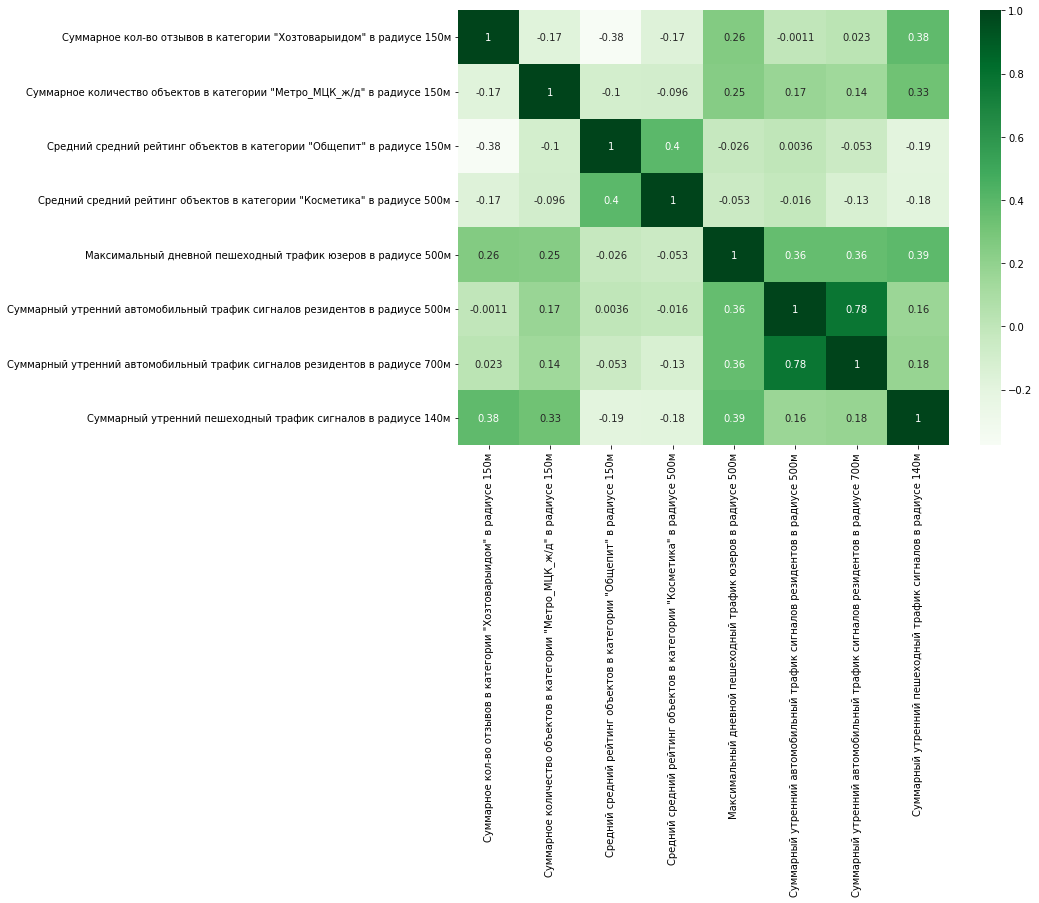

In [63]:
corr_m(clean_data[imp_cols_1])

And also threre is no very highly correlated data (>0.8).